# Player Trajectories: Understanding Them, Modeling Them

Questions of interest:
* How do players abilities change over time? 
* What are the signals of whether a player will improve or decline? Can we call a player's peak?
* How well can we predict a player's performance next year? 5 years down the line? 10?

In [373]:
from pybaseball import lahman
from pybaseball import batting_stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings 
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
warnings.filterwarnings('ignore')
%matplotlib inline

## 1: Collect Data

In [374]:
"""
# uncomment if you don't have the data and need to scrape it. takes a while but only needs to be done once
df1 = batting_stats(1900, 1910, qual=1)
df2 = batting_stats(1911, 1920, qual=1)
df3 = batting_stats(1921, 1930, qual=1)
df4 = batting_stats(1931, 1940, qual=1)
df5 = batting_stats(1941, 1950, qual=1)
df6 = batting_stats(1951, 1960, qual=1)
df7 = batting_stats(1961, 1970, qual=1)
df8 = batting_stats(1971, 1980, qual=1)
df9 = batting_stats(1981, 1990, qual=1)
df10 = batting_stats(1991, 2000, qual=1)
df11 = batting_stats(2001, 2010, qual=1)
df12 = batting_stats(2011, 2017, qual=1)
""";

In [375]:
"""
# also only needs to be done once. Concatenate the dataframes and write to csv
all_batting = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12], 0)
all_batting.shape
all_batting.to_csv('data/fg_1900_2017.csv')
""";

In [376]:
# master = lahman.master() # if you don't have it yet 
master = pd.read_csv('/Users/jledoux/Documents/projects/Saber/baseball-data/baseballdatabank-2017.1/core/Master.csv')

# 2: Data Shaping, Manipulation, Feature Engineering
As-is this data is in the shape of one row per player per year. We need to reshape it into the form of one row per player-career, with each row containing their stats from each year of their career.

I'm also going to do most of the feature engineering needed for the modeling phase in this section since I would need to repeat each change ~20 times if I wait until after the data is reshaped.

In [377]:
all_batting = pd.read_csv('data/fg_1900_2017.csv')

# NOTE: see how baseball data with r book does this. I think I need to make an adjustment here
# need this to avoid mixing up ids among players with identical names 
all_batting['birthYear'] = all_batting['Season'] - all_batting['Age']
master['Name'] = master.nameFirst + ' ' + master.nameLast
master.loc[master.birthMonth>=7,'birthYear'] = master.loc[master.birthMonth>=7,'birthYear'] + 1 
all_years = pd.merge(left=all_batting, right=master, on=['Name','birthYear'])

In [378]:
# keeping it minimal here since I'll need to re-build later anyways 
all_years = all_years[['retroID','Season','WAR']]

In [379]:
trajectories = all_years.groupby('retroID')['retroID','WAR'].mean()
# get seasons 1 through 25 for each player, merge to get 1 row per player with all seasons' data
test = all_years.sort_values(['retroID','Season'],ascending=[True,True])
max_years_considered = 25
for n in range(0,max_years_considered):
    # get each player's nth best season win share
    y_n = test.groupby('retroID').nth(n)
    y_n = y_n.add_suffix('y{}'.format(n))
    y_n = y_n.drop('Seasony{}'.format(n),1)
    trajectories = trajectories.merge(y_n, left_index=True, right_index=True,how='left')
trajectories = trajectories.drop('WAR',1)
y_vec = pd.DataFrame(test.groupby('retroID').nth(n+1)) #WAR the next year

## 3: Visualization and Exploration
What do players' WAR trajectories look like? What are some common patterns?

In [380]:
def plot_trajectory(playerid):
    player = trajectories.loc[trajectories.index==playerid]
    print(player.shape)
    print(playerid)
    #print(player.Name)
    plt.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 
        [player.iloc[0]['WARy1'], player.iloc[0]['WARy2'], player.iloc[0]['WARy3'], player.iloc[0]['WARy4'], player.iloc[0]['WARy5'],player.iloc[0]['WARy6'],player.iloc[0]['WARy7'],
    player.iloc[0]['WARy8'],player.iloc[0]['WARy9'],player.iloc[0]['WARy10'], player.iloc[0]['WARy11'], player.iloc[0]['WARy12'], player.iloc[0]['WARy13'], player.iloc[0]['WARy13'], player.iloc[0]['WARy15'],
    player.iloc[0]['WARy16'],player.iloc[0]['WARy17'],player.iloc[0]['WARy18'],player.iloc[0]['WARy19'],player.iloc[0]['WARy20']])
    plt.title(player.index)
    plt.show()

(1, 25)
aaroh101


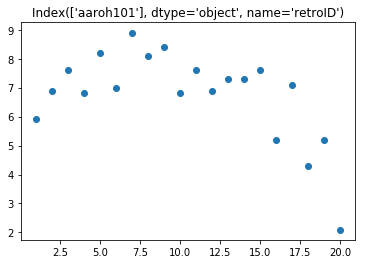

(1, 25)
bagwj001


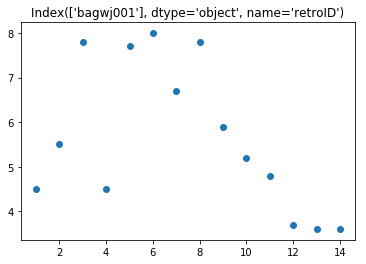

(1, 25)
bondb001


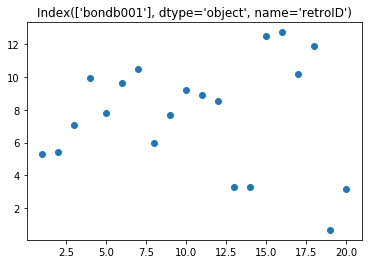

(1, 25)
bryak001


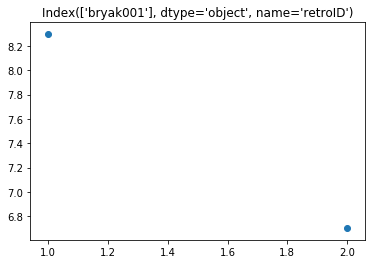

(1, 25)
cobbt101


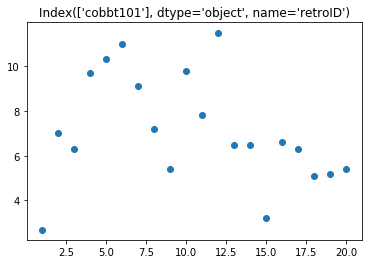

(1, 25)
dimaj101


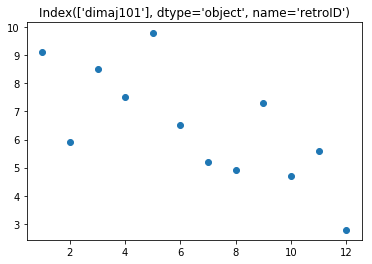

(1, 25)
donaj001


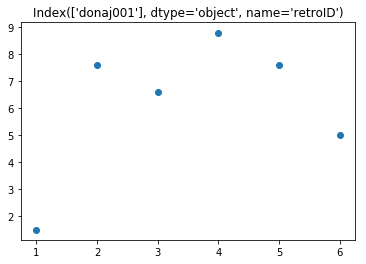

(1, 25)
foxxj101


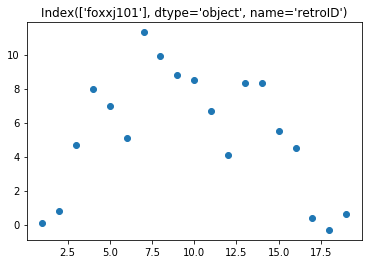

(1, 25)
gehrl101


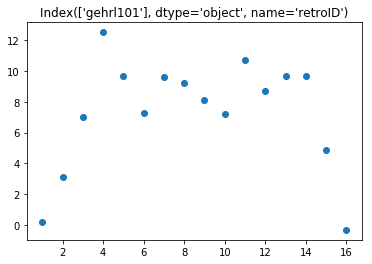

(1, 25)
gordj101


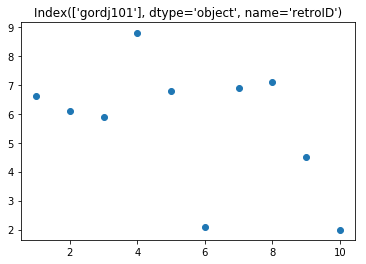

(1, 25)
hornr101


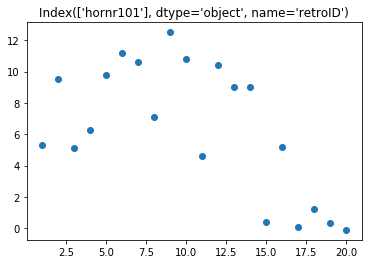

(1, 25)
lajon101


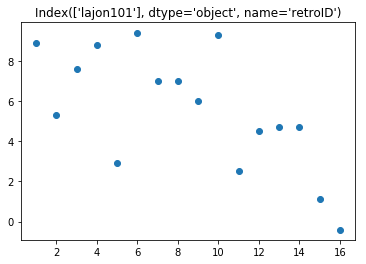

(1, 25)
lindf001


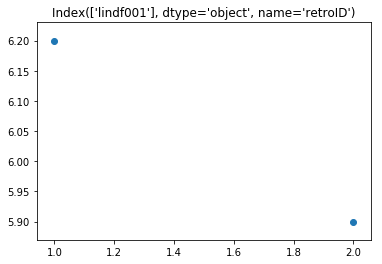

(1, 25)
mantm101


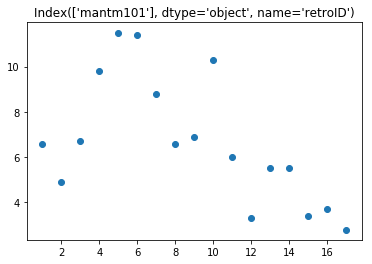

(1, 25)
mathe101


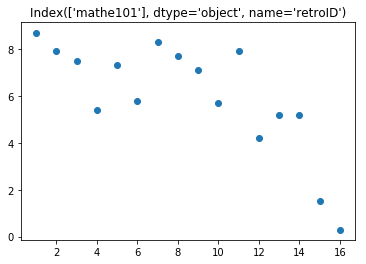

(1, 25)
maysw101


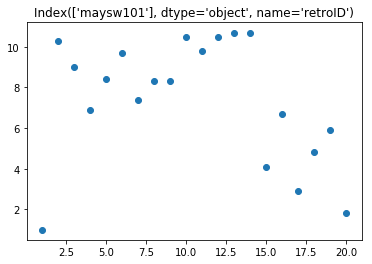

(1, 25)
musis101


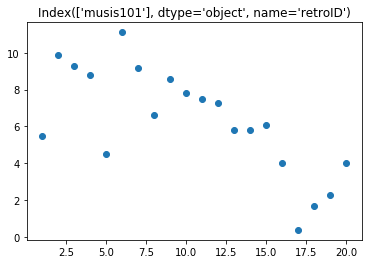

(1, 25)
ott-m101


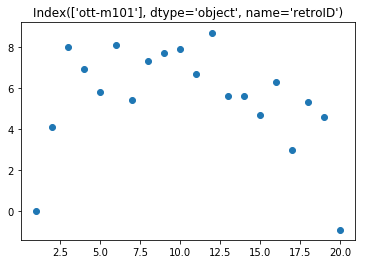

(1, 25)
pujoa001


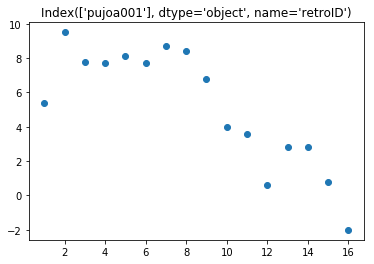

(1, 25)
robij103


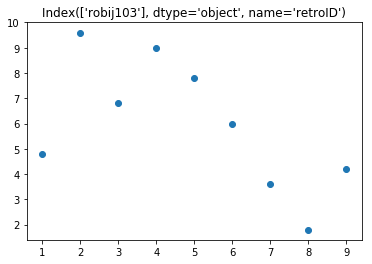

(1, 25)
rodra001


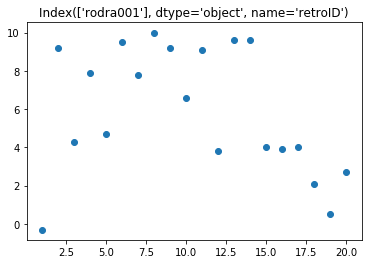

(1, 25)
ruthb101


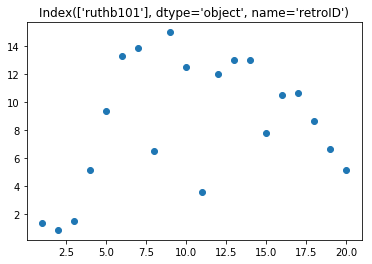

(1, 25)
schmm001


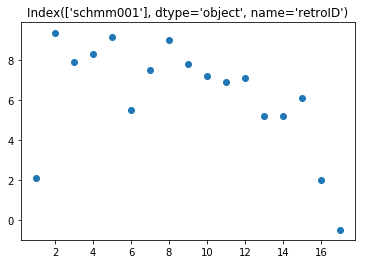

(1, 25)
speat101


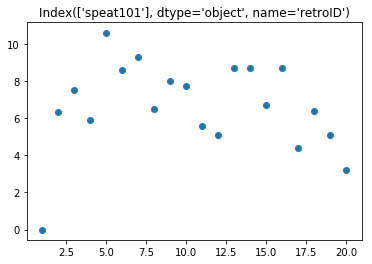

(1, 25)
troum001


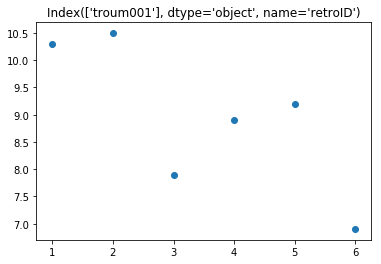

(1, 25)
vauga101


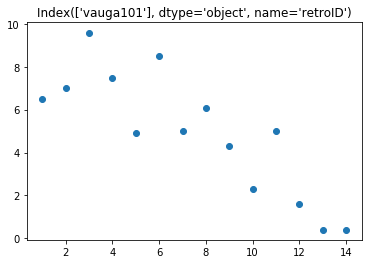

(1, 25)
wagnh101


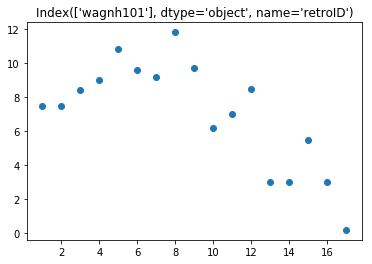

(1, 25)
willt103


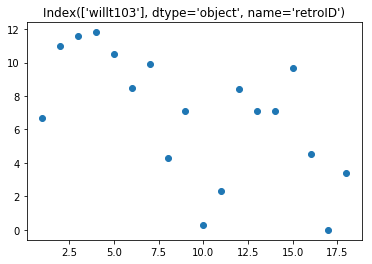

In [381]:
#great_player_ids = trajectories.loc[trajectories.WAR>5].retroID
great_player_ids = trajectories.loc[trajectories.mean(axis=1)>5].index # looks like this part changed 
for id_ in great_player_ids:
    plot_trajectory(id_)

In [382]:
all_years = pd.merge(left=all_batting, right=master, on=['Name','birthYear'])
all_years = all_years[['retroID','Season','WAR','PA']]
trajectories = all_years.groupby('retroID')['retroID','WAR'].mean()
# get seasons 1 through 25 for each player, merge to get 1 row per player with all seasons' data
test = all_years.sort_values(['retroID','Season'],ascending=[True,True])
max_years_considered = 25
for n in range(0,max_years_considered):
    # get each player's nth best season win share
    y_n = test.groupby('retroID').nth(n)
    y_n = y_n.add_suffix('y{}'.format(n))
    y_n = y_n.drop('Seasony{}'.format(n),1)
    trajectories = trajectories.merge(y_n, left_index=True, right_index=True,how='left')
trajectories = trajectories.drop('WAR',1)
y_vec = pd.DataFrame(test.groupby('retroID').nth(n+1)) #WAR the next year

In [383]:
# ignore players who didn't have 100+ PA on avg. for first three years (filters out pitchers and temp. minor-league call-ups)
trajectories2 = trajectories.loc[trajectories[['PAy1','PAy2','PAy3']].mean(axis=1)>100]
trajectories2 = trajectories2[['WARy1','WARy2','WARy3','WARy4','WARy5','WARy6','WARy7','WARy8','WARy9','WARy10',
                'WARy11','WARy12','WARy13','WARy14','WARy15','WARy16','WARy17','WARy18','WARy19','WARy20']]
# sequences need to be the same length with k-means
# forcing NAs to zero *sort of* works with WAR since it's a bad score and also a valid value (so it doesn't skew the 
# means too much) 
trajectories2 = trajectories2.fillna(0)

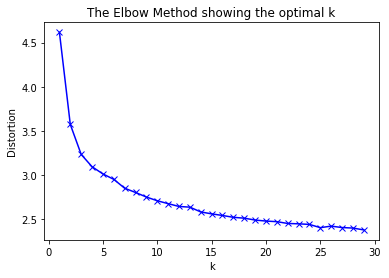

In [384]:
# k means determine k
distortions = []
K = range(1,30)
for k in K:
    model = KMeans(n_clusters=k).fit(trajectories2)
    #model.fit(trajectories)
    distortions.append(sum(np.min(cdist(trajectories2, model.cluster_centers_, 'euclidean'), axis=1))/trajectories2.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

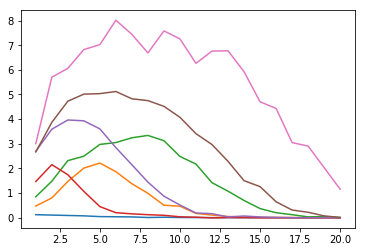

In [385]:
# k=10 looks like the final outsized jump in performance 
model = KMeans(n_clusters=7)
model.fit(trajectories2)
centers = model.cluster_centers_
[plt.plot(np.linspace(1,20,20),c) for c in centers];

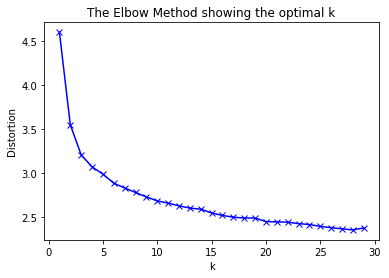

In [386]:
# not many make it to 20 seasons, so let's re-try with a smaller timeframe
trajectories2 = trajectories2[['WARy1','WARy2','WARy3','WARy4','WARy5','WARy6','WARy7','WARy8','WARy9','WARy10',
                'WARy11','WARy12','WARy13','WARy14','WARy15']]
distortions = []
K = range(1,30)
for k in K:
    model = KMeans(n_clusters=k).fit(trajectories2)
    #model.fit(trajectories)
    distortions.append(sum(np.min(cdist(trajectories2, model.cluster_centers_, 'euclidean'), axis=1))/trajectories2.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

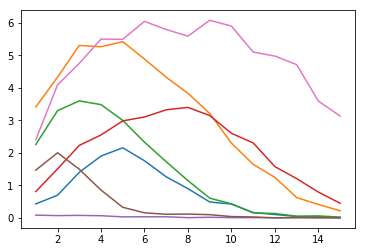

In [387]:
model = KMeans(n_clusters=7)
model.fit(trajectories2)
centers = model.cluster_centers_
[plt.plot(np.linspace(1,15,15),c) for c in centers];

## Modeling

To model trajectories we need sequential data. For this reason, the dataframe of predictor variables will contain each available statistic for each available year up until the season for which we're considering the "present." 

For a naive example, pretend we're only using past WAR to predict future WAR. This is what a player's rows in the data would look like: 

$X: [WAR_5, WAR_4, WAR_3, WAR_2, WAR_1] $

$Y: [Y1, Y2, Y3, Y4, Y5] $

Where $WAR_1$ represents WAR the season before $Y_1,$ $WAR_2$ represents WAR two seasons before $Y_1,$ and so on, all the way back to the beginning of the player's career. We will have 24 columns for each variable to represent a maximum of 24 total seasons considered. Missing variables are mean-imputed within seasons where the player was in the league, and are zero-imputed for seasons where the player did not play. For someone who had a five-year career, for example, if $Y_1$ is WAR for their 5th and final season, variables $WAR_1,...,WAR_4$ will have values, and $WAR_5,...,WAR_{24}$ will be set to 0 since the player did not participate in those seasons. 

For the target variables, we wish to predict not only next season's performance, but a player's entire future trajectory. For this reason I train multiple models representing various points in time. In the above example, $Y_1$ represents WAR one year into the future, $Y_2$ two years into the future, and so on. 

The modeling procedure looks as follows: 

1. For each player, let N equal the number of seasons they played in their career 
2. For season j in seasons 1 through (N-1), create a row in X that represents their performance in years 1 through j (i.e. if they played four seasons, they get a row for season one, seasons one and two, and seasons one through three)
3. For each row, take WAR for seasons J+1 through N as all possible Y values we'll be predicting. Fill values N through 24 with zero since they didn't play for these years. 
4. Cut 30% of player ids out of X and Y as a validation set 
5. Train 5 models using 5-fold cross validation: For each row, predict WAR in Y1, Y3, Y5, Y7, and Y9


Similarly, for the prediction procedure: 
1. Take first N years of performance data as X 
2. Take WAR for seasons (N+1,N_+3,N+5,N+7,N+9) as Y values
3. Given first N seasons, predict player's WAR in seasons N+1, N+3, ..., N+9
4. Fit a smoothing function to their predicted outputs. This is the player's predicted career trajectory (at least for the next 9 years)

In [903]:
all_batting = pd.read_csv('data/fg_1900_2017.csv')
master = pd.read_csv('/Users/jledoux/Documents/projects/Saber/baseball-data/baseballdatabank-2017.1/core/Master.csv')

# NOTE: see how baseball data with r book does this. I think I need to make an adjustment here
# need this to avoid mixing up ids among players with identical names 
all_batting['birthYear'] = all_batting['Season'] - all_batting['Age']
master['Name'] = master.nameFirst + ' ' + master.nameLast
master['birthMonth'] = master['birthMonth'].astype(float)
master['birthYear'] = master['birthYear'].astype(float)

#print(master.loc[master.birthMonth>=7,'birthYear'].head(30))
master.loc[master.birthMonth>=7,'birthYear'] = master.loc[master.birthMonth>=7,'birthYear'] + 1 
all_years = pd.merge(left=all_batting, right=master, on=['Name','birthYear'])
#print(master.loc[master.birthMonth>=7,'birthYear'].head(30))

In [904]:
print('Names in FG data: {}'.format(len(all_batting.Name.unique())))
print('IDs successfully matched: {}'.format(len(all_years.retroID.unique())))

Names in FG data: 14873
IDs successfully matched: 14381


In [905]:
# drop or make dummies of everything that can't/shouldn't be placed directly in a model
drops = ['bbrefID','finalGame','debut','nameGiven','nameLast','nameFirst','deathCity','deathState','deathDay',
        'deathMonth','deathYear','birthCity','birthState','birthCountry','birthDay','birthMonth','birthYear',
        'Name','throws','bats','Age Rng','Dol','deathCountry','playerID', 'Contact% (pfx)','Contact% (pi)',
        'LD','O-Contact% (pi)','O-Contact% (pfx)','O-Swing% (pi)','O-Swing% (pfx)','Swing% (pfx)','Swing% (pi)',
        'Z-Contact% (pfx)','Z-Contact% (pi)','Zone% (pfx)','Zone% (pi)','WPA','Unnamed: 0','BUH','wRC','GB']
to_join = all_years[['retroID','throws','bats']] # drop for now, join back later
to_join.index = to_join['retroID']
to_join = to_join.drop('retroID',1)
to_join = pd.get_dummies(to_join)
to_join['retroID'] = to_join.index
to_join = to_join.groupby('retroID').nth(1) # only keep first row for each player.. these things basically never change
all_years.index = all_years['retroID'] # required for concatenation
all_years = all_years.drop(drops,1)

In [906]:
# feature engineering (used later in modeling stage) done here for convenience

# divide hits, walks by atbats
#all_years[['H','1B','2B','3B','HR','BB','HBP']] = all_years[['H','1B','2B','3B','HR','BB','HBP']].divide(all_years['PA'])
for col in ['H','1B','2B','3B','HR','BB','HBP','BU']:
    all_years[col] = all_years[col]/all_years['PA'] 
    
# drop obp, slg, ops, BsR, Clutch since they're linear combinations of features that we already have
# keeping them in the model along with component parts would cause a multicollinearity problem, and I want explainable feaure importances here
all_years = all_years.drop(['OBP','SLG','OPS','AVG','BB%','BsR','Clutch'],1)

# GP needs to be scaled by number of games per season to make it useful across eras 
# only worrying about 1900 - present because that's all I'm using in this analysis 
all_years.loc[all_years['Season']>=1962,'G'] = all_years.loc[all_years['Season']>=1962,'G'] / 162
all_years.loc[(all_years['Season']>=1920) & (all_years['Season']<1962),'G'] = all_years.loc[(all_years['Season']>=1920) & (all_years['Season']<1962),'G'] / 154
all_years.loc[all_years['Season']==1919,'G'] = all_years.loc[all_years['Season']==1919,'G'] / 140
all_years.loc[(all_years['Season']>=1904) & (all_years['Season']<1919),'G'] = all_years.loc[(all_years['Season']>=1904) & (all_years['Season']<1919),'G'] / 154
all_years.loc[all_years['Season']<1904,'G'] = all_years.loc[all_years['Season']<1904,'G'] / 140



In [907]:
# dropping for now due to very limited availability
pfx_drops = ['FA% (pfx)','FT% (pfx)','FC% (pfx)','FS% (pfx)','FO% (pfx)','SI% (pfx)','SL% (pfx)',
            'CU% (pfx)','KC% (pfx)','EP% (pfx)','CH% (pfx)','SC% (pfx)','KN% (pfx)', 'UN% (pfx)', 'vFA (pfx)','vFT (pfx)','vFC (pfx)','vFS (pfx)','vFO (pfx)', 'vSI (pfx)', 'vSL (pfx)',
            'vCU (pfx)','vKC (pfx)','vEP (pfx)','vCH (pfx)','vSC (pfx)', 'vKN (pfx)', 'FA-X (pfx)','FT-X (pfx)','FC-X (pfx)',
            'FS-X (pfx)','FO-X (pfx)','SI-X (pfx)','SL-X (pfx)','CU-X (pfx)','KC-X (pfx)','EP-X (pfx)','CH-X (pfx)','SC-X (pfx)',
            'KN-X (pfx)','FA-Z (pfx)','FT-Z (pfx)','FC-Z (pfx)','FS-Z (pfx)','FO-Z (pfx)','SI-Z (pfx)','SL-Z (pfx)','CU-Z (pfx)',
            'KC-Z (pfx)','EP-Z (pfx)','CH-Z (pfx)','SC-Z (pfx)','KN-Z (pfx)','wFA (pfx)','wFT (pfx)','wFC (pfx)','wFS (pfx)',
            'wFO (pfx)','wSI (pfx)','wSL (pfx)','wCU (pfx)','wKC (pfx)','wEP (pfx)','wCH (pfx)','wSC (pfx)','wKN (pfx)',
            'wFA/C (pfx)','wFT/C (pfx)','wFC/C (pfx)','wFS/C (pfx)','wFO/C (pfx)','wSI/C (pfx)','wSL/C (pfx)','wCU/C (pfx)',
            'wKC/C (pfx)','wEP/C (pfx)','wCH/C (pfx)','wSC/C (pfx)','wKN/C (pfx)','Z-Swing% (pfx)']

all_years = all_years.drop(pfx_drops, axis=1)

In [908]:
pi_drops = ['FA% (pi)','FC% (pi)','FS% (pi)','SI% (pi)','SL% (pi)',
            'CU% (pi)','CH% (pi)','KN% (pi)', 'vFA (pi)','vFC (pi)','vFS (pi)','vSI (pi)', 'vSL (pi)',
            'vCU (pi)','vCH (pi)', 'vKN (pi)', 'FA-X (pi)','FC-X (pi)',
            'FS-X (pi)','SI-X (pi)','SL-X (pi)','CU-X (pi)','CH-X (pi)',
            'KN-X (pi)','FA-Z (pi)','FC-Z (pi)','FS-Z (pi)','SI-Z (pi)','SL-Z (pi)','CU-Z (pi)',
            'CH-Z (pi)','KN-Z (pi)','wFA (pi)','wFC (pi)','wFS (pi)', 'Pace (pi)'
            'wSI (pi)','wSL (pi)','wCU (pi)','wCH (pi)','wKN (pi)',
            'wFA/C (pi)','wFC/C (pi)','wFS/C (pi)','wSI/C (pi)','wSL/C (pi)','wCU/C (pi)',
            'wCH/C (pi)','wKN/C (pi)','wCS/C (pi)','wSB/C (pi)','wXX/C (pi)','wSB (pi)','wCS (pi)',
           'XX-Z (pi)','SB-Z (pi)','XX-X (pi)','SB-X (pi)','CS-X (pi)','CS-Z (pi)','vXX (pi)',
           'vCS (pi)','XX% (pi)', 'SB% (pi)','CS% (pi)', 'CS% (pi)','wXX (pi)','vSB (pi)','Z-Swing% (pi)']
all_years = all_years.drop(pi_drops, axis=1)

ValueError: labels ['Pace (pi)wSI (pi)'] not contained in axis

In [ ]:
# need to drop either runs per pitch type or its standardized couterpart. I'll drop the non-standardized
pitch_weight_drops = ['wCH','wSL','wKN','wFB','wCT','wCB','wSF','wCT',
                     'FB','SF','wSB']
all_years = all_years.drop(pitch_weight_drops,1)

In [ ]:
other_pitch_drops = ['SL%','CH%','KN%','FB% (Pitch)','CT%','CB%','SF%',
                    'KN%','SLv','CHv','KNv','FBv','CTv','CBv','SFv',
                    'KNv','XX%']

all_years = all_years.drop(other_pitch_drops, axis=1)

In [ ]:
# for years 2 through 25, create dataset for predicting war based on all year n-1, ..., n-m 
# mean-impute missing values once dataframe is ready
# repeat for all years, concat together, imputing nonexistent years values with zeros 
# result:
# for a player's last season, predict war given all prev. seasons. column_m = col for year n - 1 
# for a player's second season, predict war given last year's performance. column_m = col for year 1, n-2,...,n-m all zeros
# for a player's first s
dataframes = []

for year in range(24,-1,-1):
    print('generating data for predicting season {} based on all previous seasons'.format(year))
    #trajectories = all_years.groupby('retroID')['retroID'].mean()
    #trajectories = pd.DataFrame(all_years['retroID'].drop_duplicates())
    test = all_years.sort_values(['retroID','Season'],ascending=[True,True])
    trajectories = pd.DataFrame(test.groupby('retroID').nth(year)['WAR']) # the basis for the dataframe built in the next loop
    m=0 # backwards counter of year (lower number = closer to year we're predicting)
    for n in range(year-1,-1,-1): # start with the year before "year", get data for that year and all that came before it. minus 2 bc year before AND zero indexing  
        # get each player's nth season's war
        y_n = test.groupby('retroID').nth(n) 
        #teams_n = pd.get_dummies(y_n['Team'])
        #y_n = y_n.join(teams_n, how='left')
        y_n = y_n.drop('Team',1)
        #y_n = y_n.drop('retroID',1) 
        y_n = y_n.add_suffix('y{}'.format(m))
        #y_n['_{}'.format(n)] = n
        trajectories = trajectories.join(y_n, how='left')
        m+=1
    trajectories = trajectories.fillna(trajectories.mean()) # naively mean-impute all missing values
    y_vec1 = pd.DataFrame(test.groupby('retroID').nth(year)) #WAR the year "year"
    y_vec2 = pd.DataFrame(test.groupby('retroID').nth(year+2))
    y_vec3 = pd.DataFrame(test.groupby('retroID').nth(year+4))
    y_vec4 = pd.DataFrame(test.groupby('retroID').nth(year+6))
    y_vec5 = pd.DataFrame(test.groupby('retroID').nth(year+8))
    trajectories = trajectories.join(y_vec1['WAR'], how='left',rsuffix='Y1')
    trajectories = trajectories.join(y_vec2['WAR'], how='left',rsuffix='Y3')
    trajectories = trajectories.join(y_vec3['WAR'], how='left',rsuffix='Y5')
    trajectories = trajectories.join(y_vec4['WAR'], how='left',rsuffix='Y7')
    trajectories = trajectories.join(y_vec5['WAR'], how='left',rsuffix='Y9')
    trajectories = trajectories.drop('WAR',1)
    dataframes.append(trajectories)
    print(trajectories.shape)

In [ ]:
#dataframes[7][['WARy0','WARy1','WARY5']]

In [ ]:
data = pd.concat(dataframes, axis=0)

In [ ]:
data.shape

In [ ]:
#data.loc[data.index=='aaroh101']

In [909]:
trajectories = data

In [910]:
trajectories = trajectories.join(to_join,how='left') # can't join anymore since need more than just index to join on
trajectories = trajectories.fillna(0)

In [911]:
y = trajectories[['WARY1','WARY3','WARY5','WARY7','WARY9']]
X = trajectories.drop(['WARY1','WARY3','WARY5','WARY7','WARY9'],1)

In [912]:
# create difference variabels for the most recent 4 years
# 4 years is arbitrary, but we probably don't need this for all years 
# only doing this for a select few variables to avoid a prohibitively large feature space 
X['wardiff1'] = X['WARy0'] - X['WARy1']
X['wardiff2'] = X['WARy1'] - X['WARy2']
X['wardiff3'] = X['WARy2'] - X['WARy3']
X['wardiff4'] = X['WARy3'] - X['WARy4']

X['Hdiff1'] = X['Hy0'] - X['Hy1']
X['Hdiff2'] = X['Hy1'] - X['Hy2']
X['Hdiff3'] = X['Hy2'] - X['Hy3']
X['Hdiff4'] = X['Hy3'] - X['Hy4']

X['wOBAdiff1'] = X['wOBAy0'] - X['wOBAy1']
X['wOBAdiff2'] = X['wOBAy1'] - X['wOBAy2']
X['wOBAdiff3'] = X['wOBAy2'] - X['wOBAy3']
X['wOBAdiff4'] = X['wOBAy3'] - X['wOBAy4']


X['BABIPdiff1'] = X['BABIPy0'] - X['BABIPy1']
X['BABIPdiff2'] = X['BABIPy1'] - X['BABIPy2']
X['BABIPdiff3'] = X['BABIPy2'] - X['BABIPy3']
X['BABIPdiff4'] = X['BABIPy3'] - X['BABIPy4']

In [913]:
import statsmodels.api as sm

In [914]:
all_player_ids = np.unique(X.index)
print(len(all_player_ids))

14380


In [915]:
# ~70% of players used for training, 30% used as a holdout set 
# stratifying by player and not row to avoid info leakage from training to eval data
training_players = all_player_ids[:10000] 
test_players = all_player_ids[10001:]
X_train = X.loc[X.index.isin(training_players)]
X_test = X.loc[X.index.isin(test_players)]

y_train = y.loc[y.index.isin(training_players)]
y_test = y.loc[y.index.isin(test_players)]

In [916]:
X_ind_train = X_train.index
X_ind_test = X_test.index

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [917]:
print(X.shape)
print(y.shape)

(72761, 2302)
(72761, 5)


In [902]:
# test for predicting next year's war 
model = sm.OLS(list(y['WARY1'].astype(float)),X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     65.14
Date:                Sat, 30 Dec 2017   Prob (F-statistic):               0.00
Time:                        18:08:42   Log-Likelihood:            -1.0570e+05
No. Observations:               72761   AIC:                         2.146e+05
Df Residuals:                   71132   BIC:                         2.296e+05
Df Model:                        1629                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
+WPAy0                0.0311      0.01

In [ ]:
# random forest, 4 -> 5 year model 

In [809]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [810]:
param_grid = {
    'n_estimators': [256], 
    'max_features': ['sqrt'],#['sqrt', 'log2', None],
    'criterion': ['mse'],
    'max_depth': [None],
    'n_jobs': [-1]
}

In [811]:
forest = RandomForestRegressor()

In [812]:
grid_search1 = GridSearchCV(cv=3, estimator=forest, param_grid=param_grid,verbose=2)
grid_search3 = GridSearchCV(cv=3, estimator=forest, param_grid=param_grid,verbose=2)
grid_search5 = GridSearchCV(cv=3, estimator=forest, param_grid=param_grid,verbose=2)
grid_search7 = GridSearchCV(cv=3, estimator=forest, param_grid=param_grid,verbose=2)
grid_search9 = GridSearchCV(cv=3, estimator=forest, param_grid=param_grid,verbose=2)

In [813]:
grid_search1.fit(X_train, y_train['WARY1'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.5min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.3min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [256], 'max_features': ['sqrt'], 'criterion': ['mse'], 'max_depth': [None], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [666]:
grid_search3.fit(X_train, y_train['WARY3'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.5min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.7min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [256], 'max_features': ['sqrt'], 'criterion': ['mse'], 'max_depth': [None], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [667]:
grid_search5.fit(X_train, y_train['WARY5'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.4min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.1min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [256], 'max_features': ['sqrt'], 'criterion': ['mse'], 'max_depth': [None], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [668]:
grid_search7.fit(X_train, y_train['WARY7'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.0min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.1min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [256], 'max_features': ['sqrt'], 'criterion': ['mse'], 'max_depth': [None], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [669]:
grid_search9.fit(X_train, y_train['WARY9'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.0min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total= 1.0min
[CV] criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1 
[CV]  criterion=mse, max_depth=None, max_features=sqrt, n_estimators=256, n_jobs=-1, total=11.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [256], 'max_features': ['sqrt'], 'criterion': ['mse'], 'max_depth': [None], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [814]:
print(grid_search1.best_score_) # .488 before
print(grid_search3.best_score_)
print(grid_search5.best_score_)
print(grid_search7.best_score_)
print(grid_search9.best_score_)

0.488936400516


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [671]:
print(grid_search1.best_params_)
print(grid_search3.best_params_)
print(grid_search5.best_params_)
print(grid_search7.best_params_)
print(grid_search9.best_params_)

{'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 256, 'n_jobs': -1}
{'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 256, 'n_jobs': -1}
{'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 256, 'n_jobs': -1}
{'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 256, 'n_jobs': -1}
{'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 256, 'n_jobs': -1}


In [838]:
model1 = grid_search1.best_estimator_
model3 = grid_search3.best_estimator_
model5 = grid_search5.best_estimator_
model7 = grid_search7.best_estimator_
model9 = grid_search9.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
#grid_search.cv_results_

In [839]:
yhat1 = model1.predict(X_test)
yhat3 = model3.predict(X_test)
yhat5 = model5.predict(X_test)
yhat7 = model7.predict(X_test)
yhat9 = model9.predict(X_test)

ValueError: Number of features of the model must match the input. Model n_features is 2598 and input n_features is 2614 

In [ ]:
yhat9

In [840]:
y = pd.DataFrame(y_test)
y.columns = ['y1','y3','y5','y7','y9']

In [841]:
print(X_test.WARy0.head())
print(y.head())

0    0.2
1    0.1
2    2.5
3    1.7
4    0.6
Name: WARy0, dtype: float64
           y1   y3   y5   y7   y9
retroID                          
pecob001  0.5  0.0  0.0  0.0  0.0
pecob001  0.2  0.0  0.0  0.0  0.0
pecob001  0.1  0.5  0.0  0.0  0.0
pecob001  2.5  0.2  0.0  0.0  0.0
pecob001  1.7  0.1  0.5  0.0  0.0


In [842]:
#y.loc[y.y>8]

In [843]:
y['yhat1'] = yhat1
y['yhat3'] = yhat3
y['yhat5'] = yhat5
y['yhat7'] = yhat7
y['yhat9'] = yhat9

In [844]:
y['sqerr1'] = (y['y1'] - y['yhat1'])**2
y['sqerr3'] = (y['y3'] - y['yhat3'])**2
y['sqerr5'] = (y['y5'] - y['yhat5'])**2
y['sqerr7'] = (y['y7'] - y['yhat7'])**2
y['sqerr9'] = (y['y9'] - y['yhat9'])**2

In [845]:
#y.sort_values('sqerr', ascending=False)
y.head()

,y1,y3,y5,y7,y9,yhat1,yhat3,yhat5,yhat7,yhat9,sqerr1,sqerr3,sqerr5,sqerr7,sqerr9
retroID,,,,,,,,,,,,,,,
pecob001,0.5,0.0,0.0,0.0,0.0,0.233594,0.169531,0.118750,0.009375,0.042578,0.070972,0.028741,0.014102,0.000088,0.001813
pecob001,0.2,0.0,0.0,0.0,0.0,0.539062,0.266797,0.133594,0.107812,-0.006641,0.114963,0.071181,0.017847,0.011624,0.000044
pecob001,0.1,0.5,0.0,0.0,0.0,1.315234,0.703125,0.296094,0.133984,0.067969,1.476795,0.041260,0.087672,0.017952,0.004620
pecob001,2.5,0.2,0.0,0.0,0.0,0.640234,0.535547,0.267969,0.096094,0.054687,3.458728,0.112592,0.071807,0.009234,0.002991
pecob001,1.7,0.1,0.5,0.0,0.0,0.409375,0.244922,0.188281,0.159375,0.067188,1.665713,0.021002,0.097169,0.025400,0.004514


In [846]:
#forest.fit(X,y)

In [847]:
def plot_importances(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns
    feature_names = feature_names[indices]
    indices = indices[0:30]
    feature_names = feature_names[0:30]
    
    f, ax = plt.subplots(figsize=(11, 9))
    plt.title("Feature ranking", fontsize = 20)
    plt.bar(range(30), importances[indices],
        color="b", 
        align="center")
    plt.xticks(range(30), indices)
    plt.xlim([-1, 30])
    plt.ylabel("importance", fontsize = 18)
    plt.xlabel("index of the feature", fontsize = 18)
    plt.xticks(range(30), feature_names, rotation=45);

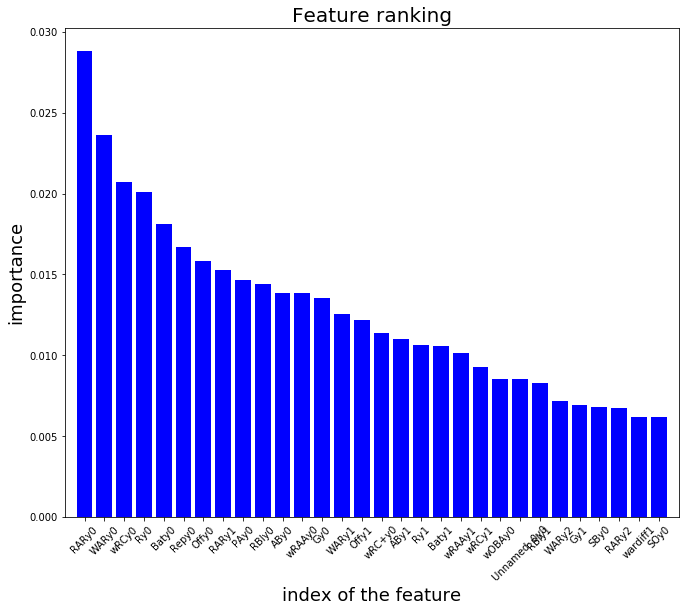

In [848]:
plot_importances(model1)

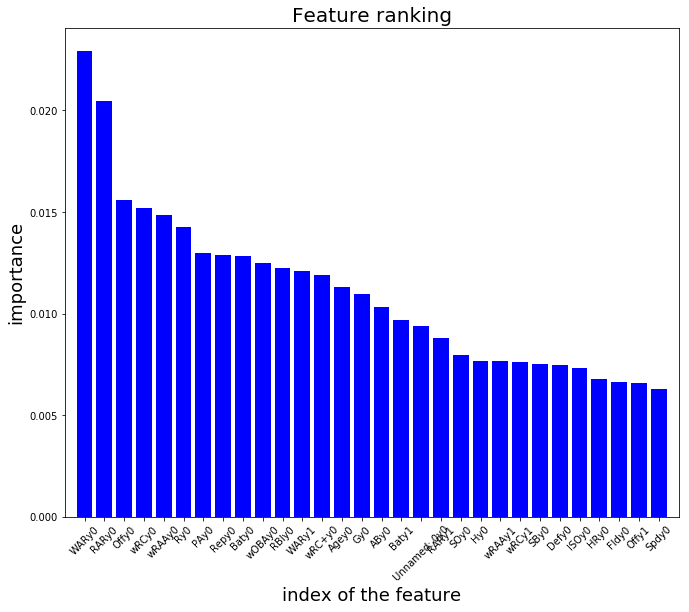

In [686]:
plot_importances(model3)

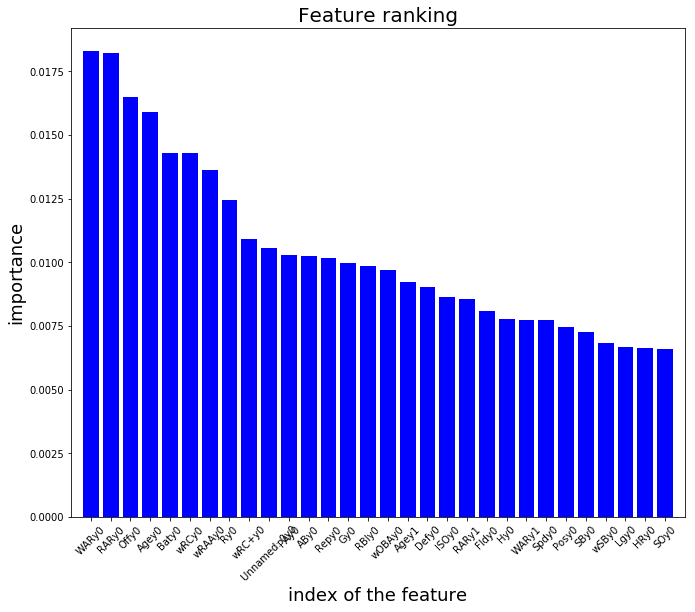

In [687]:
plot_importances(model5)

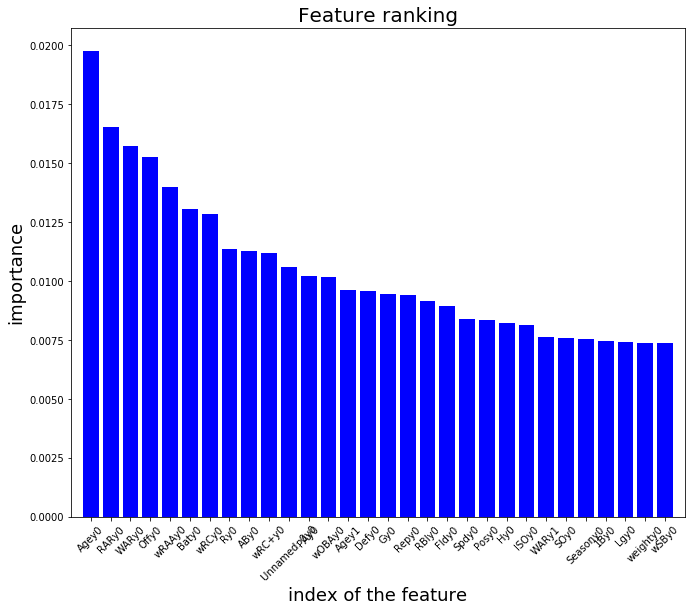

In [688]:
plot_importances(model7)

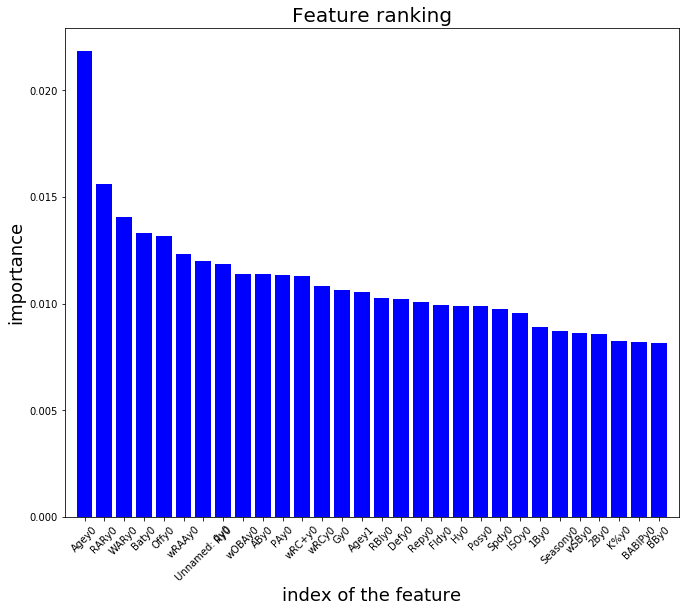

In [689]:
plot_importances(model9)

In [740]:
def plot_trajectory_predictions(playerid):
    player = great_player_preds.loc[great_player_preds.index==playerid]
    print(player.shape)
    print(playerid)
    player = player.reset_index(drop=True)
    player['season'] = player.index
    plt.plot(player['season'], 
    player['y1'], color='red')
    plt.plot(player['season'], 
        player['yhat1'], color='blue')
    plt.title(player.iloc[0].index)
    plt.show()

In [741]:
great_player_ids = np.unique(y.loc[y.y1>7].index)[0:30]

In [742]:
y['retroID'] = y.index

In [743]:
y = y.iloc[::-1]

In [744]:
great_player_preds = y.loc[y.index.isin(great_player_ids)]

(12, 16)
pedrd001


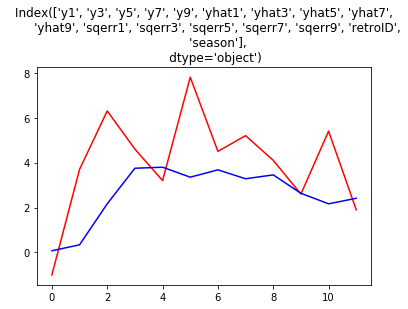

(23, 16)
peret001


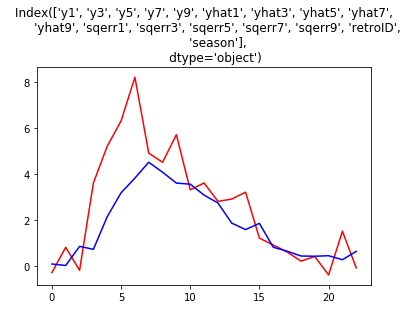

(13, 16)
petrr101


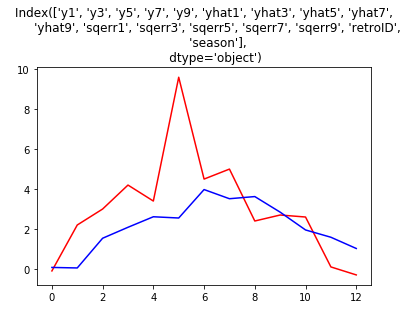

(16, 16)
piazm001


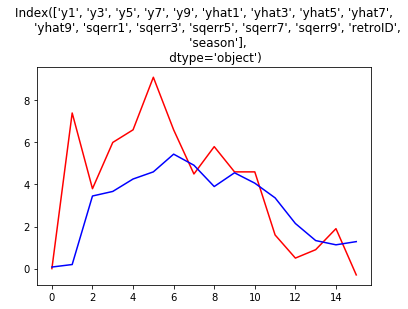

(17, 16)
portd001


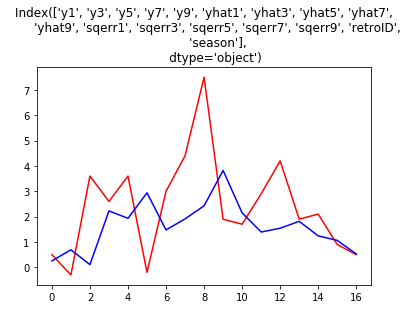

(9, 16)
poseb001


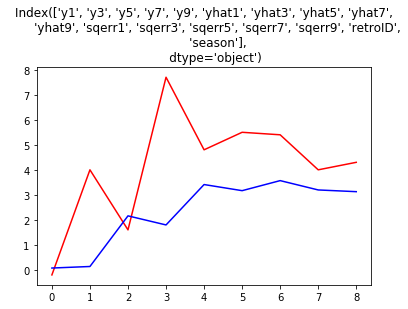

(12, 16)
puckk001


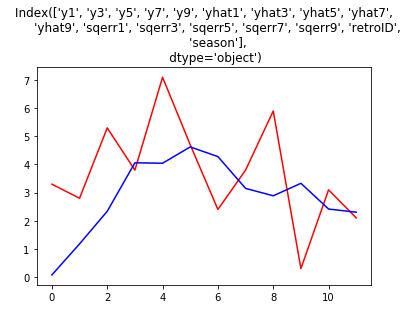

(17, 16)
pujoa001


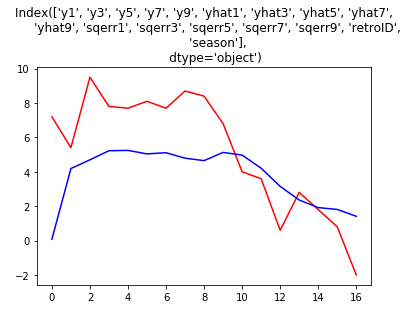

(22, 16)
raint001


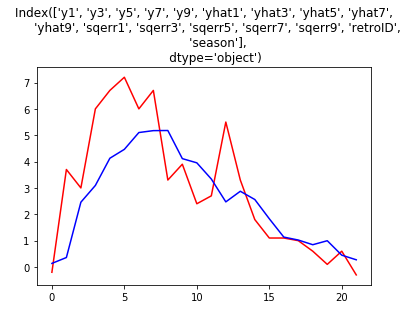

(13, 16)
ramih003


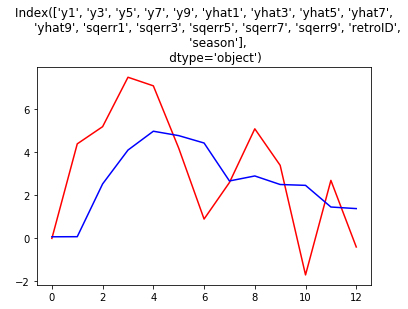

(19, 16)
ramim002


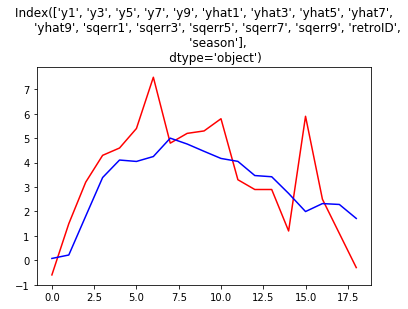

(10, 16)
reisp101


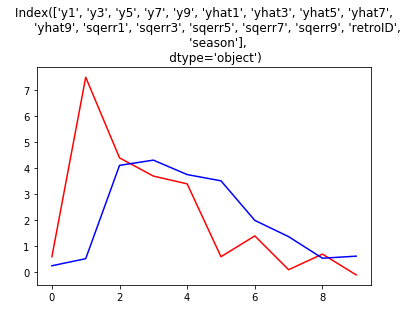

(16, 16)
ricej001


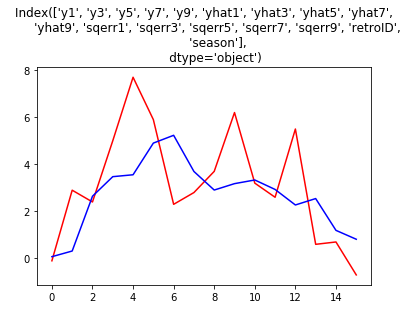

(21, 16)
ripkc001


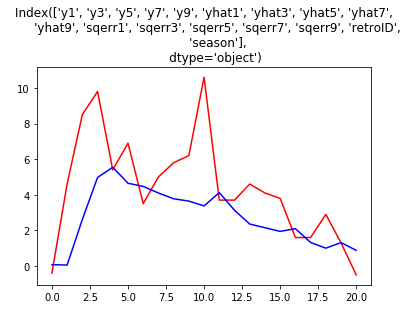

(23, 16)
robib104


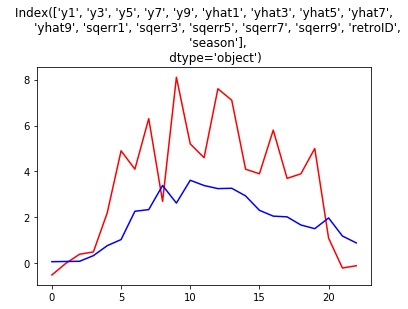

(21, 16)
robif103


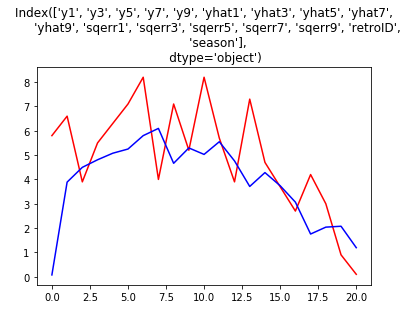

(10, 16)
robij103


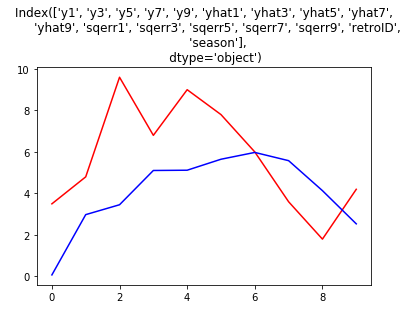

(22, 16)
rodra001


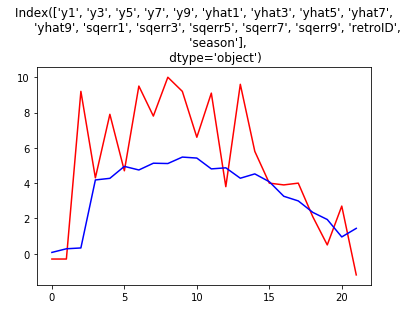

(17, 16)
roles001


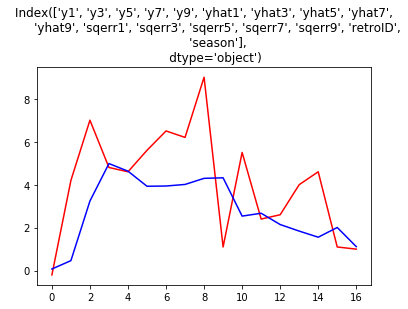

(10, 16)
rosea101


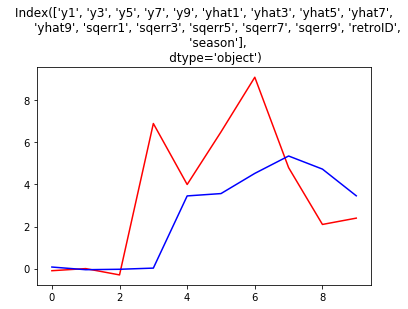

(24, 16)
rosep001


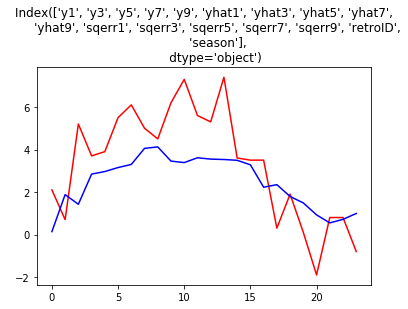

(22, 16)
ruthb101


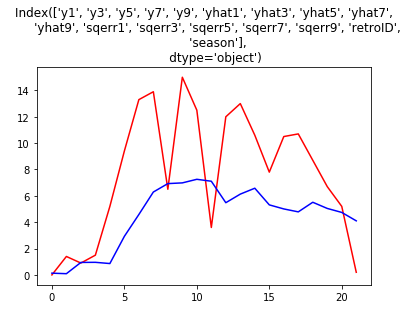

(16, 16)
sandr001


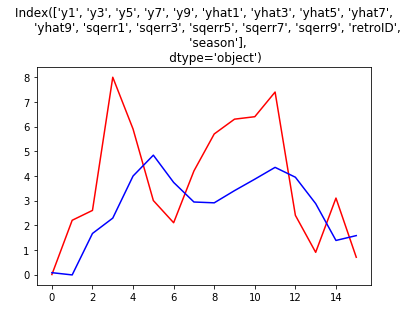

(15, 16)
santr102


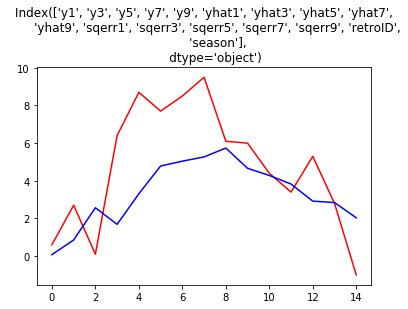

(18, 16)
schmm001


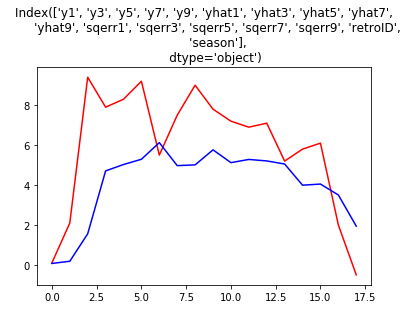

(3, 16)
seagc001


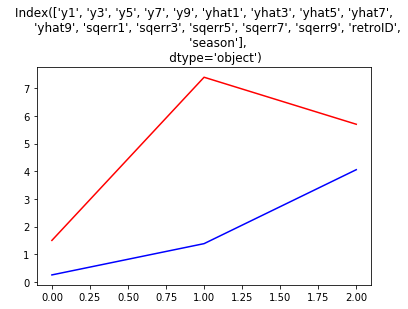

(12, 16)
seymc101


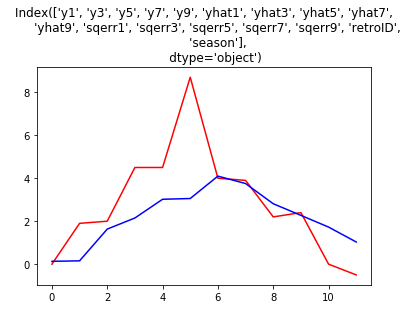

(14, 16)
shecj101


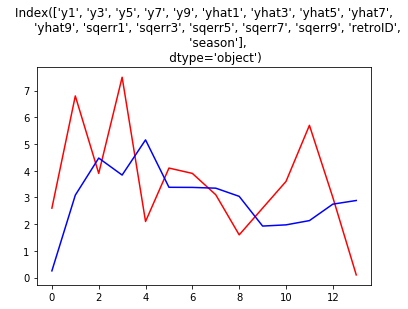

(22, 16)
shefg001


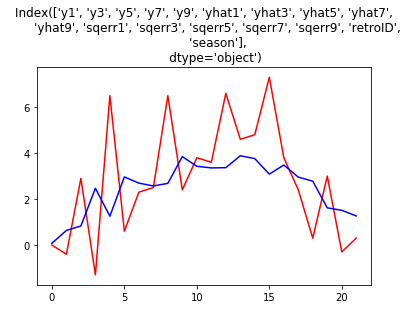

(20, 16)
simma101


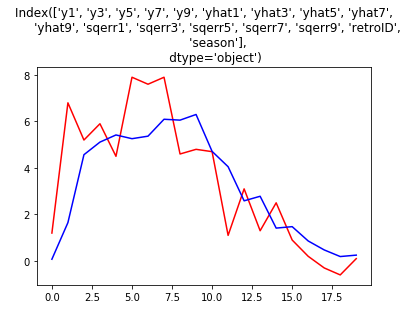

In [745]:
for id_ in great_player_ids:
    plot_trajectory_predictions(id_)

In [774]:
def plot_trajectory_predictions2(playerid,n):
    player = great_player_preds.loc[great_player_preds.index==playerid].iloc[[n]]
    print(player.shape)
    print(playerid)
    player = player.reset_index(drop=True)
    player['season'] = player.index
    plt.plot([1,3,5,7,9], 
    [player['y1'],player['y3'],player['y5'],player['y7'],player['y9']], color='red')
    plt.plot([1,3,5,7,9], 
        [player['yhat1'],player['yhat3'],player['yhat5'],player['yhat7'],player['yhat9']], color='blue')
    plt.title(player.iloc[0].index)
    plt.ylim(ymin=-2,ymax=10)
    plt.show()

(1, 16)
pedrd001


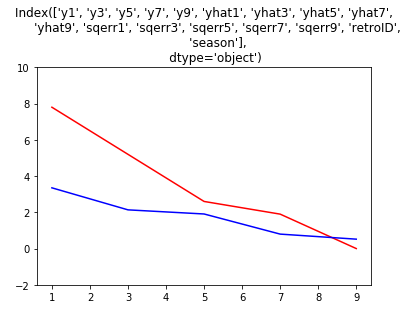

(1, 16)
peret001


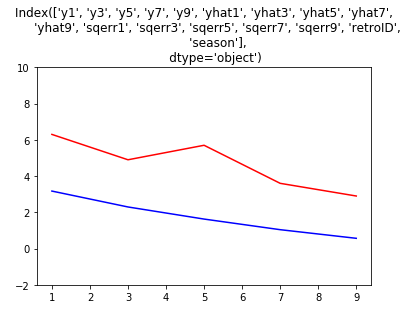

(1, 16)
petrr101


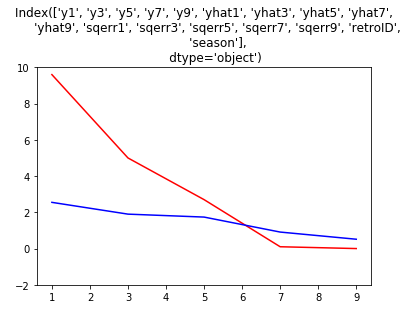

(1, 16)
piazm001


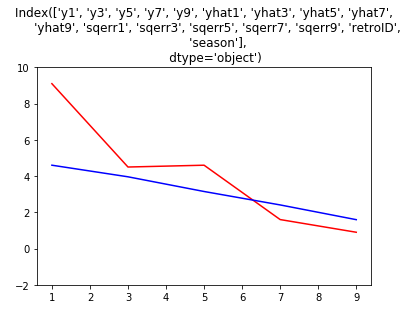

(1, 16)
portd001


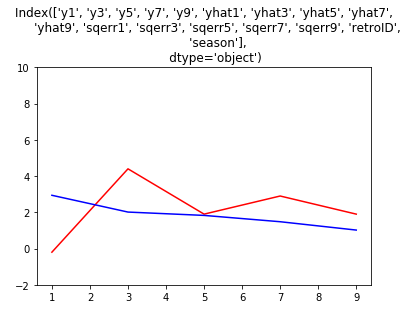

(1, 16)
poseb001


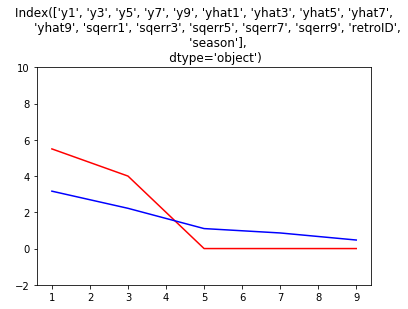

(1, 16)
puckk001


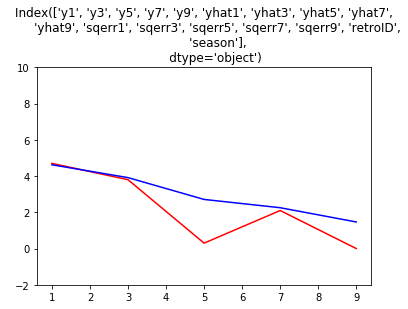

(1, 16)
pujoa001


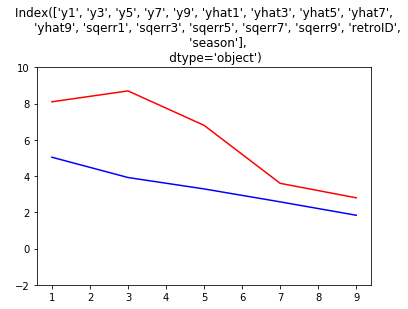

(1, 16)
raint001


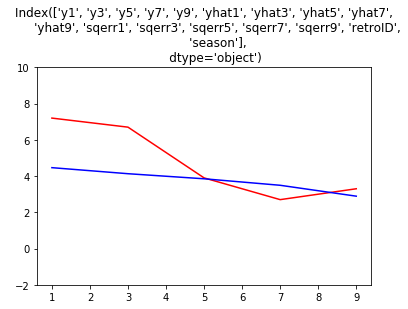

(1, 16)
ramih003


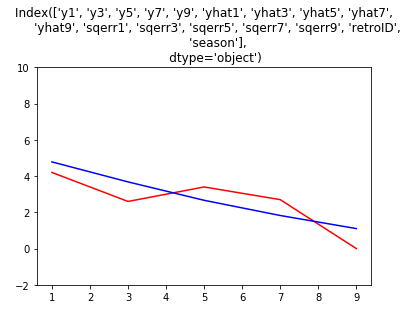

(1, 16)
ramim002


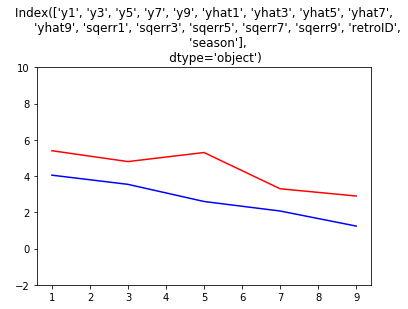

(1, 16)
reisp101


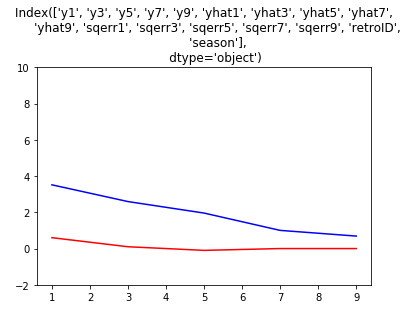

(1, 16)
ricej001


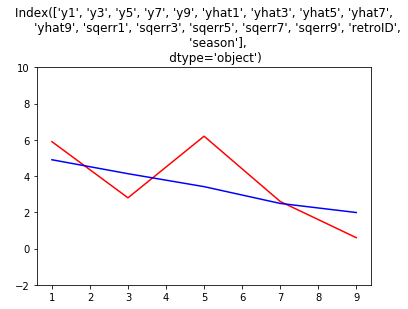

(1, 16)
ripkc001


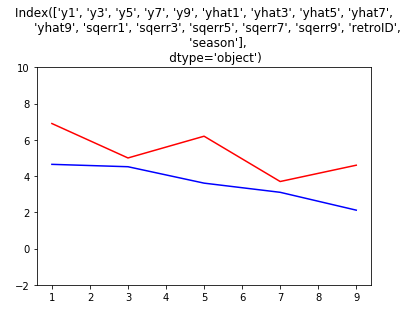

(1, 16)
robib104


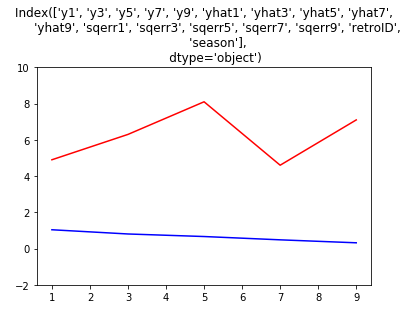

(1, 16)
robif103


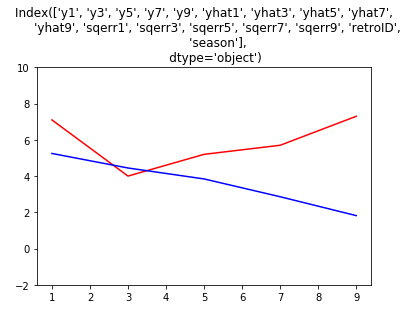

(1, 16)
robij103


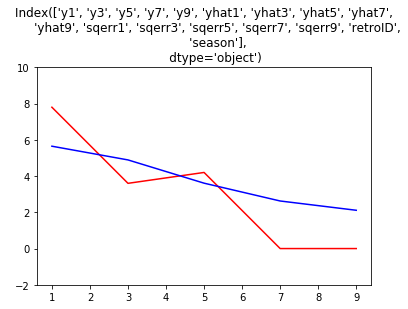

(1, 16)
rodra001


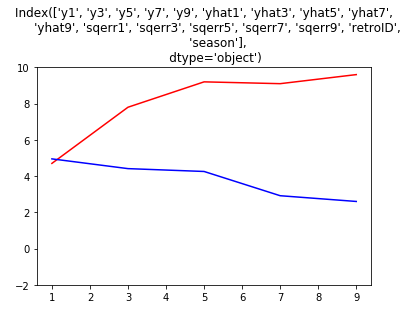

(1, 16)
roles001


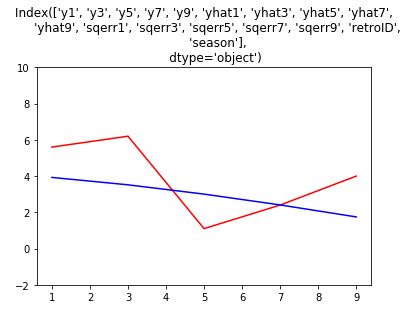

(1, 16)
rosea101


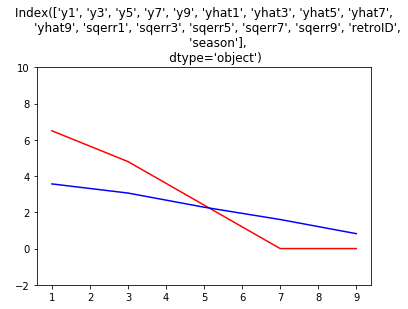

(1, 16)
rosep001


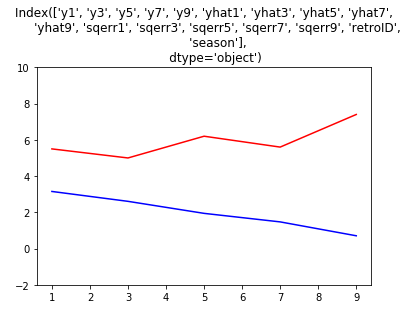

(1, 16)
ruthb101


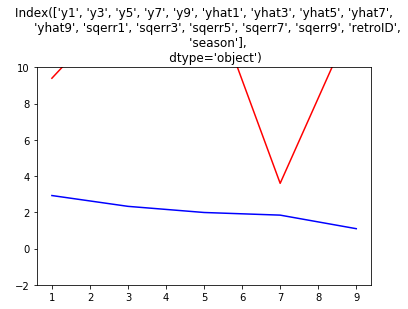

(1, 16)
sandr001


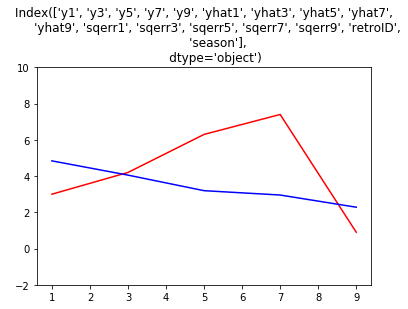

(1, 16)
santr102


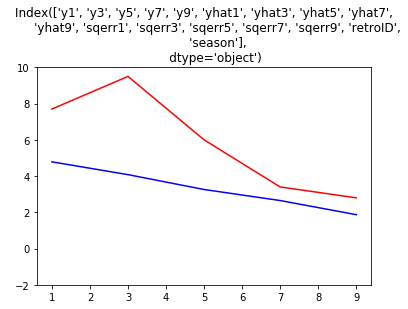

(1, 16)
schmm001


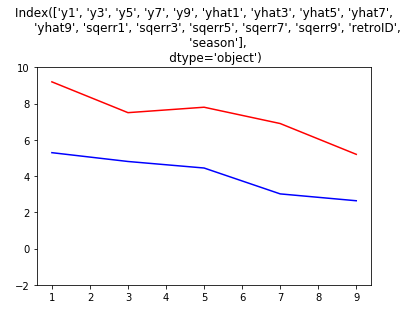

IndexError: positional indexers are out-of-bounds

In [776]:
for id_ in great_player_ids:
    plot_trajectory_predictions2(id_,5)

In [ ]:
great_player_preds

In [762]:
playerid = 'simma101'